# Load the Necessary Packages 

In [1]:
#Neural Networks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from skimage import io, transform

#Matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
import numpy as np

#For image processing and the Dataset class
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from skimage import io, transform
from PIL import Image

#CSV and File management
import os
import pandas as pd

#Plot Recall, Precision, and F1 neatly
from utility.evaluation import load_type_dict, plot_evaluation

#Display matplotlib within jupyter notebook
plt.ion()

In [2]:
data_folder = os.path.join(os.getcwd(), "data")

train_df = pd.read_csv(os.path.join(data_folder, "Train_hot.csv"))
test_df  = pd.read_csv(os.path.join(data_folder, "Test_hot.csv" ))

[6, 7, 8, 9]
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)


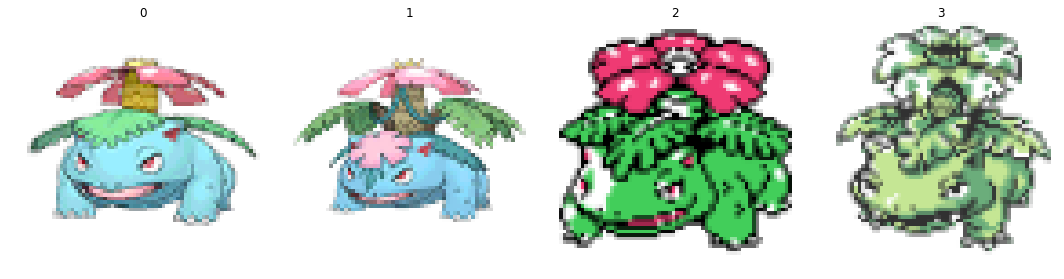

                                             pokemon dex_number normal  \
6  /home/tariq/PokemonTypeNN/data/xydex/venusaur.png          3      0   
7  /home/tariq/PokemonTypeNN/data/xydex/venusaurm...          3      0   
8    /home/tariq/PokemonTypeNN/data/gsc/venusaur.png          3      0   
9    /home/tariq/PokemonTypeNN/data/rby/venusaur.png          3      0   

  fighting flying poison ground rock bug ghost  ... blue3 green3 red4 blue4  \
6        0      0      1      0    0   0     0  ...   182    151  134   230   
7        0      0      1      0    0   0     0  ...   118    130   75   117   
8        0      0      1      0    0   0     0  ...   123     58   57   175   
9        0      0      1      0    0   0     0  ...   167    140   97   102   

  green4 proportion0 proportion1 proportion2 proportion3 proportion4  
6    170      0.0999      0.0629      0.0465      0.0447      0.0358  
7     84      0.0875      0.0539      0.0486      0.0424      0.0392  
8     77      0.2432

In [3]:
def plot_all(dex_num, df):

    df_idxs = [i for i in range(0,len(df)) if df["dex_number"].iloc[i] == dex_num]
    print(df_idxs)
    fig = plt.figure(figsize=(15,15))
    labels = pd.DataFrame(columns=list(df))
    
    for i in range(0, len(df_idxs)):
        
        ax = plt.subplot(1, len(df_idxs), i+1)
        plt.tight_layout()
        ax.set_title(i)
        ax.axis("off")
        pkm_image = io.imread(df["pokemon"].iloc[ df_idxs[i] ])
        plt.imshow(pkm_image)
        print(np.array(pkm_image).shape)
        labels = labels.append(df.iloc[ df_idxs[i]])

    plt.show()
    return labels

#plot an example
temp_labels = plot_all(3,train_df)
print(temp_labels)

In [4]:
class PokemonDataset(Dataset):
    """Pokemon Dataset. """
    
    def __init__(self, csv_file_loc, transform=None):
        """
        Args:
            csv_file_loc (string): Path to the csv file
            transform (callable, optional): optional transform to be applied to the samples"""
        
        self.df = pd.read_csv(csv_file_loc)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        ###
        #Read the labels
        ###
        labels = self.df.iloc[index, 2:2+18].values
        labels = labels.astype("float").reshape(len(labels))
        
        ###
        #Read the 1-hot vector
        #
        #don't include proportion information; proportions are at the end
        less = (len(self.df.columns)-(2+18))//4
        one_hot = self.df.iloc[index, 2+18:-less].values
        one_hot = one_hot.astype("float").reshape(len(one_hot))
         
        if self.transform:
            one_hot = self.transform(one_hot)
            
        #Concat the images and labels as a "sample" dictionary
        sample = {"one_hot": one_hot, "labels":labels}
        return sample, index
    
    def getpokemon(self, index):
        return self.df["pokemon"].iloc[index]
        

# Load the Pokemon Datasets for the Neural Network

In [5]:
use_devset = False

theTransformations = None#transforms.Compose([transforms.ToTensor()])

###
#Load the Sets
###

#Trainset uses theTransformations; Test set only uses ToTensor
trainset = PokemonDataset(csv_file_loc = os.path.join(data_folder, "Train_hot.csv"),
                         transform= theTransformations)
testset  = PokemonDataset(csv_file_loc = os.path.join(data_folder, "Test_hot.csv" ),
                         transform = None)

if use_devset:
    devset   = PokemonDataset(csv_file_loc = os.path.join(data_folder, "Dev_hot.csv"  ),
                             transform = None)

###
# Create DataLoaders
###
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                         shuffle=True,  num_workers=4) #num_workers = 2
testloader  = torch.utils.data.DataLoader(testset , batch_size=16,
                                         shuffle=False, num_workers=4)
if use_devset:
    devloader   = torch.utils.data.DataLoader(devset  , batch_size=16,
                                         shuffle=False, num_workers=4)

classes = list(train_df)[2:2+18]
x_len = ((len(train_df.columns)-(2+18))//4) * 3
print("Classes :: ",classes)
print("Input vector length :: ", x_len)

Classes ::  ['normal', 'fighting', 'flying', 'poison', 'ground', 'rock', 'bug', 'ghost', 'steel', 'fire', 'water', 'grass', 'electric', 'psychic', 'ice', 'dragon', 'dark', 'fairy']
Input vector length ::  15


In [6]:
for i, (minibatch, index) in enumerate(trainloader):
    print(minibatch)

{'one_hot': tensor([[182., 152., 139., 130.,  94.,  79., 163., 142., 147., 203., 186., 186.,
          75.,  43.,  31.],
        [251., 156., 172., 205., 133., 144., 151., 170., 178., 178., 104., 114.,
         229., 210., 215.],
        [223., 156.,  98., 244., 203., 121., 159., 106.,  62., 247., 247., 249.,
         170., 130.,  75.],
        [ 87.,  81.,  80.,  76.,  85.,  76.,  36.,  36.,  36., 190., 146., 139.,
          38.,  45.,  39.],
        [ 57., 106., 155., 106.,  96.,  77.,  34.,  30.,  22.,  20.,  35.,  51.,
         161., 137.,  89.],
        [214., 205., 144., 179., 166., 128., 128., 103.,  73., 102., 200., 114.,
          69., 129.,  72.],
        [119., 175., 127., 194., 226., 146.,  80., 108.,  85.,  94.,  97.,  88.,
         155., 164., 141.],
        [196., 161., 126., 132., 101.,  75., 226., 216., 133., 225., 225., 226.,
         160., 134.,  88.],
        [207., 157., 108., 144., 104.,  56., 187., 154.,  36., 232., 218.,  78.,
         231., 232., 233.],
       

{'one_hot': tensor([[ 97.,  90.,  85.,  79.,  98., 125., 118., 152., 197., 162., 159., 158.,
          58.,  52.,  50.],
        [176., 138., 186., 226., 196., 243., 109.,  88., 113., 210., 169., 232.,
          91.,  91.,  91.],
        [104., 192., 205.,  84., 154., 153., 137., 174., 169., 119., 220., 232.,
          69., 120., 120.],
        [236., 250., 250., 210., 221., 236., 160., 170., 182.,  92.,  95., 105.,
         164., 172., 170.],
        [182., 148., 163., 230., 203., 215., 157., 162., 175., 215., 218., 223.,
         136.,  87., 111.],
        [ 60., 110.,  55.,  87., 165.,  58.,  29.,  88.,  43., 145., 171., 141.,
         213., 218., 214.],
        [ 29.,  45.,  57.,  67.,  85.,  99., 146., 152., 157., 224., 226., 226.,
         219., 220., 222.],
        [142.,  72.,  58., 212.,  76.,  51.,  54.,  50.,  49., 198., 151., 114.,
         254., 196.,  89.],
        [161., 161., 186., 185., 185., 207., 209., 210., 223.,  98., 103., 125.,
         123., 120., 151.],
       

{'one_hot': tensor([[108.,  88.,  69., 205., 151., 118., 251., 171., 152.,  66.,  48.,  36.,
         241., 206., 109.],
        [163.,  76.,  26.,  44.,  20.,   6., 196., 156., 102., 199., 128.,  43.,
         234., 195., 137.],
        [111., 163., 218.,  73.,  98., 132., 202., 222., 243.,  26.,  37.,  51.,
          84., 129., 180.],
        [129.,  86.,  56., 251., 218., 107.,  39.,  24.,  14., 180., 160., 127.,
         167., 137.,  69.],
        [137.,  80.,  61., 209., 153.,  99., 254., 196.,  89., 210.,  81.,  54.,
          59.,  52.,  49.],
        [238., 205., 102., 177.,  92.,  32., 201., 165., 102., 193., 134.,  49.,
         236., 229., 235.],
        [238., 220., 121., 199., 166., 104., 161., 145.,  74., 136., 103.,  58.,
         115., 163., 201.],
        [196., 169., 116., 241., 213., 122., 243., 243., 245., 127., 109.,  75.,
         162., 136.,  80.],
        [128., 178., 211., 188., 224., 245., 229., 166.,  82., 232., 245., 244.,
         239., 203., 110.],
       

# Define a Convolutional Neural Network

In [7]:
class FeatureNet(nn.Module):
    def __init__(self,name):
        super(FeatureNet,self).__init__()
        
        self.setName(name)
        
        self.fc1 = nn.Linear(in_features = 15, out_features = 20)
        self.fc2 = nn.Linear(in_features = 20, out_features = 40)
        self.fc3 = nn.Linear(in_features = 40, out_features = 60)
        self.fc4 = nn.Linear(in_features = 60, out_features = 36)
        self.fc5 = nn.Linear(in_features = 36, out_features = 18)
        
        self.bnorm1 = nn.BatchNorm1d(num_features=20)
        self.bnorm2 = nn.BatchNorm1d(num_features=40)
        self.bnorm3 = nn.BatchNorm1d(num_features=60)
        self.bnorm4 = nn.BatchNorm1d(num_features=36)

        
    def forward(self, x):
        x = F.relu(self.bnorm1(self.fc1(x)))
        x = F.relu(self.bnorm2(self.fc2(x)))
        x = F.relu(self.bnorm3(self.fc3(x)))
        x = F.relu(self.bnorm4(self.fc4(x)))
        x = F.sigmoid(self.fc5(x))
        return x
    
    def setName(self, name):
        self.name = name
    
    def getName(self):
        return self.name
    
    

In [10]:
type_of_network = "5FC"

if(type_of_network == "5FC"):
    net = FeatureNet("5FC"+str(x_len))
else:
    raise ValueError("Improper Type of Network")

print("Finished setting up Neural Network :: ", net.getName())

Finished setting up Neural Network ::  5FC15


# Define a loss function and an optimizer

In [11]:
import torch.optim as optim

loss_fn = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001) #0.001

use_cuda = False

#saved_losses=[]

# Train the Network

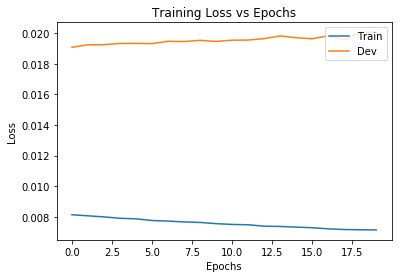

In [20]:
#Determine whether to load the model

load_model = True
saved_losses = {"train":[],
                "dev":[]}

if load_model:
    state = torch.load(os.path.join(os.getcwd(), "model",net.getName()+".pt"))
    net.load_state_dict(state["state_dict"])
    optimizer.load_state_dict(state["optimizer"])
    saved_losses["train"] = state["train_loss"]
    saved_losses["dev"]   = state["dev_loss"]
    
    plt.title("Training Loss vs Epochs")
    plt.plot(saved_losses["train"], label="Train")
    plt.plot(saved_losses["dev"], label="Dev")
    plt.legend(loc="upper right")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    


# NOTE: I am using the Test Set for the Dev Set here

In [19]:
max_epochs = 10

epochs_to_print = 25

if use_cuda:
    net.cuda()
    
    
data_loaders = {"train":trainloader, 
                "dev":testloader}
data_lengths = {"train":len(trainset), 
                "dev":  len(testset) }

for epoch in range(max_epochs):
    
    for phase in ["train", "dev"]:
        
        running_loss = 0.0
        
        if phase == "train":
#             optimizer = scheduler(optimizer, epoch)
            net.train(True)
        else:
            net.train(False)
            
            
        for i, (minibatch, index) in enumerate(data_loaders[phase]):
            #get the inputs
            one_hot, labels = minibatch["one_hot"], minibatch["labels"]
            if use_cuda:
                one_hot = one_hot.float().cuda()
                labels = labels.float().cuda()
            else:
                one_hot = one_hot.float()
                labels = labels.float()


            #zero the parameter gradients
            optimizer.zero_grad()

            #forward + backward + optimize
            outputs = net(one_hot) #net.forward()
            loss = loss_fn(outputs, labels)
            
            if phase == "train":
                loss.backward()
                optimizer.step()

            #print statistics
            running_loss += loss.item()

        running_loss /= data_lengths[phase]
        saved_losses[phase].append(running_loss)
        print('%5s [%d, %5d] loss: %.3f' %
               (phase, epoch + 1, i + 1, running_loss)) 

### 
# Save the Model
###
saveloc = os.path.join(os.getcwd(), "model")
print("*************************************************************************")
if(not os.path.exists(saveloc)):
    try:
        os.mkdir(saveloc)
    except OSError:
        print("Creation of the directory %s failed" %saveloc)
    else:
        print("Successfully created the directory %s" %saveloc)
print("*************************************************************************")
state = {
    "epoch": epoch,
    "state_dict": net.state_dict(),
    "optimizer": optimizer.state_dict(),
    "train_loss": saved_losses["train"],
    "dev_loss"  : saved_losses["dev"]
}
torch.save(state, os.path.join(saveloc,net.getName()+".pt"))
print("Finished training")

train [1,    42] loss: 0.007
  dev [1,     8] loss: 0.020
train [2,    42] loss: 0.007
  dev [2,     8] loss: 0.020
train [3,    42] loss: 0.007
  dev [3,     8] loss: 0.020
train [4,    42] loss: 0.007
  dev [4,     8] loss: 0.020
train [5,    42] loss: 0.007
  dev [5,     8] loss: 0.020
train [6,    42] loss: 0.007
  dev [6,     8] loss: 0.020
train [7,    42] loss: 0.007
  dev [7,     8] loss: 0.020
train [8,    42] loss: 0.007
  dev [8,     8] loss: 0.020
train [9,    42] loss: 0.007
  dev [9,     8] loss: 0.020
train [10,    42] loss: 0.007
  dev [10,     8] loss: 0.020
*************************************************************************
*************************************************************************
Finished training


# Test the Network

In [158]:
#Specify the loader
somevar = "test"

if(somevar == "train"):
    loader = trainloader
    theset = trainset
elif(somevar == "test"):
    loader = testloader
    theset = testset
elif(somevar == "dev"):
    loader = devloader
    theset = devset
else:
    raise ValueError("Please specify what to test on!")

/home/tariq/anaconda3/envs/pokemon/lib/python3.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in true_divide


True Pos  ::  [1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 3. 1. 1. 3. 0. 0. 0. 1.]
False Neg ::  [16.  2. 10.  8.  4.  4. 13.  5.  4.  6. 12. 14.  2.  9.  6.  3.  4.  6.]
False Pos ::  [12. 11. 16.  8.  4. 12. 12. 14.  9.  8. 12. 13.  8. 10.  2. 10.  3. 16.]
Actual    ::  [13. 12. 17.  8.  5. 13. 13. 14.  9.  9. 15. 14.  9. 13.  2. 10.  3. 17.]
****************************************
Correctly identified class percentage (True Pos)::  [0.07692308 0.08333333 0.05882353 0.         0.2        0.07692308
 0.07692308 0.         0.         0.11111111 0.2        0.07142857
 0.11111111 0.23076923 0.         0.         0.         0.05882353]
Recall (average) ::  0.11555555555555556
Precision (average) ::  0.07555555555555556
F1 Score (average) ::  0.12666666666666668
Correctly identified Pokemon percentage ::  0.04032258064516129
Perfectly identified Pokemon :: 
/home/tariq/PokemonTypeNN/data/xydex/brionne.png  ::  ['water']
/home/tariq/PokemonTypeNN/data/xydex/yungoos.png  ::  ['normal']
/home/tariq/Pokem

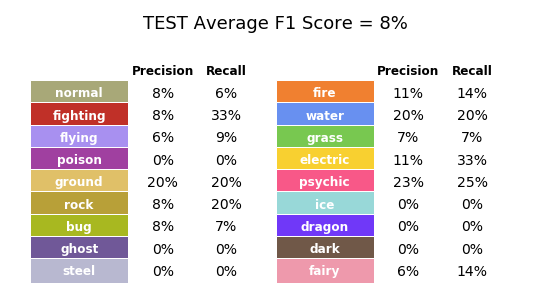

In [159]:
true_pos  = np.zeros(len(classes)) #array of number of times a class was successfully predicted
false_pos = np.zeros(len(classes)) #array of number of times a class was guessed when it should NOT have been guessed
false_neg = np.zeros(len(classes)) #array of number of times a class was not guessed when it should have been guessed
actual_dist = np.zeros(len(classes)) #array of actual number of classes present in the test set

correct_pokemon = [] #list of Pokemon that were perfectly predicted 
pokemon_guesses = {} #dictionary of Pokemon and the NN's type guess
threshold = 0.5

if use_cuda:
    #bring back to CPU so that we can do train/test evaluation
    net.cpu()

with torch.no_grad():
    for i, (minibatch, index) in enumerate(loader):
        one_hot, labels = minibatch["one_hot"], minibatch["labels"]
        one_hot = one_hot.float()
        labels = labels.float()
        outputs = net(one_hot)
        
        for j in range(one_hot.shape[0]):
            
            #see which indices are above our threshold
            poss_indices = outputs[j] >= threshold
            
            #we haven't identified a type! pick the largest type as the prediction
            if(sum(poss_indices) < 1):
                big_class_index = np.argmax(outputs[j].numpy())
                outputs[j] = torch.zeros(outputs[j].shape, dtype=torch.uint8)
                outputs[j][big_class_index] = 1
                
            #there are too many types identified! Pick the largest two
            elif(sum(poss_indices) > 2):
                temp_outputs = outputs[j].numpy()
                big_class_index = np.argsort(temp_outputs)[-2:]
                outputs[j] = torch.zeros(outputs[j].shape, dtype=torch.uint8)
                outputs[j][big_class_index] = 1
                
            #only 1 or 2 classes beat the threshold! Set only those to 1; everything else to 0
            else:
                outputs[j] = torch.zeros(outputs[j].shape, dtype=torch.uint8)
                outputs[j][poss_indices] = 1
            
            #create a dictionary of Pokemon and the NN's prediction of its typing
            predicted_type = [classes[c] for c in range(len(classes)) if outputs[j][c] == 1]
            pokemon_guesses[theset.getpokemon(index.numpy()[j])] = predicted_type
            #print(theset.getpokemon(index.numpy()[j]), "\'s type :: ", predicted_type)
            
            
            #Gather NN stats
            numpy_labels  = labels[j].numpy()
            numpy_outputs = outputs[j].numpy()
            
            #number of Pokemon perfectly guessed by NN
            if(np.array_equal(numpy_labels, numpy_outputs)):
                correct_pokemon.append(theset.getpokemon(index.numpy()[j]))
            
            #number of classes present in the test set
            actual_dist[numpy_labels == 1] += 1
            
            #counts the number of correctly identified classes
            #also counts the number of guessed classes by the NN
            for t in range(len(classes)):
                if numpy_labels[t] ==1 and numpy_outputs[t] == 1:
                    true_pos[t] += 1
                    
                if numpy_labels[t] == 1 and numpy_outputs[t] == 0:
                    false_pos[t] += 1
                
                if numpy_labels[t] == 0 and numpy_outputs[t] == 1:
                    false_neg[t] += 1
            
            
       # _, predicted = torch.max(outputs, 1)

         # following code is onlyl for single image identification
#         for j in range(images.shape[0]):
#             print(testset.getpokemon(index.numpy()[j])," \'s type:: ", classes[predicted[j]])
#             if(labels.numpy()[j][predicted[j]] == 1):
#                 class_correct[predicted[j]] = class_correct[predicted[j]]+1
#                 correct_pokemon.append(testset.getpokemon(index.numpy()[j]))
    
precision = (true_pos) / ( (true_pos) + (false_pos))
precision = np.round(precision, decimals=2)
recall    = (true_pos) / ( (true_pos) + (false_neg))
recall    = np.round(recall, decimals=2)
F1 = 2 * precision * recall/ (precision + recall)
F1 = np.round(F1, decimals=2)

nprec = len(classes)
nrec = len(classes)
nf1 = len(classes)

mean_Precision = 0
mean_Recall = 0
mean_F1 = 0

for t in range(0, len(classes)):
    if(not np.isnan(precision[t])):
        mean_Precision += precision[t]
    else:
        nprec -= 1
    
    if(not np.isnan(recall[t])):
        mean_Recall += recall[t]
    else:
        nrec -= 1
        
    if(not np.isnan(F1[t])):
        mean_F1 += F1[t]
    else:
        nf1 -= 1
        
mean_Precision /= nprec
mean_Recall    /= nrec
mean_F1        /= nf1

accuracy = np.sum(true_pos)/np.sum(actual_dist)

plot_evaluation(somevar.upper(), recall, precision, accuracy)

print("True Pos  :: ", true_pos)
print("False Neg :: ", false_neg)
print("False Pos :: ", false_pos)
print("Actual    :: ", actual_dist)
print("****************************************")
print("Correctly identified class percentage (True Pos):: ", true_pos/actual_dist)
print("Recall (average) :: ", mean_Recall)
print("Precision (average) :: ", mean_Precision)
print("F1 Score (average) :: ", mean_F1)
print("Correctly identified Pokemon percentage :: ", len(correct_pokemon)/theset.__len__())
print("Perfectly identified Pokemon :: ")
for pkm in correct_pokemon:
    print(pkm, " :: ", pokemon_guesses[pkm])
    

#print("Random Guess accuracy :: ", (1/18))


In [20]:
someloc = os.path.join(os.getcwd(), "data", "Train_hot.csv")
somedf = pd.read_csv(someloc)
less = (len(somedf.columns)-(2+18))//4
print(less)
# print(somedf.iloc[0,2:2+18])
print(somedf.iloc[0,2+18:-less])

5
red0       99
blue0     252
green0     90
red1       55
blue1     120
green1     51
red2       97
blue2     204
green2     91
red3       16
blue3      36
green3     15
red4       28
blue4      23
green4     22
Name: 0, dtype: object
